<a href="https://colab.research.google.com/github/YoshifumiMiyagi/PECARN-Group1-/blob/main/PECARN_Group_1_%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3%EF%BC%88keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# CSVファイルを読み込む
df = pd.read_csv('/content/TBI PUD 10-08-2013.csv')
# 使用された説明変数とCTスキャンの必要性を示す目的変数をリストにする

variables_of_interest = [
    'AgeTwoPlus',         # 年齢
    'High_impact_InjSev', # 外傷の重症度
    'LOCSeparate',        # 意識喪失の履歴
    'LocLen',             # 意識喪失の持続時間
    'HA_verb',            # 頭痛の有無
    'HASeverity',         # 頭痛の重症度
    'Vomit',              # 嘔吐の履歴
    'VomitNbr',           # 嘔吐の回数
    'ActNorm',            # 保護者の観察
    'GCSTotal',           # GCSスコア
    'AMS',                # 精神状態の変化
    'SFxBas',             # 基底頭蓋骨骨折の兆候
    'SFxPalp',            # 触知可能な頭蓋骨骨折
    'Hema',               # 頭皮血腫
    'HemaLoc',            # 頭皮血腫の位置
#    'HospHeadPosCT',      # 目的変数（CTスキャンと2日以上の入院の必要性）
    'PosCT'               # 目的変数（CTスキャンの必要性）
]
# 説明変数と目的変数のみを抽出
df_selected = df[variables_of_interest]

In [99]:
dat = df_selected[df_selected['PosCT'] != 92]
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
df2 = pd.DataFrame(imputer.fit_transform(dat))
df2.columns = dat.columns

from sklearn.model_selection import train_test_split
X, y = df2.iloc[:,:-1], df2.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

# Keras

In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [101]:
modelCheckpoint = ModelCheckpoint(filepath = 'model_0.keras',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min')

In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test   = scaler.transform(x_test)

In [103]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [104]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=9, activation="relu", input_shape=(x_train.shape[-1],) ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=9, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

#initial_weights = model.get_weights()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 9)                   │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 9)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 244 (976.00 B)

 Trainable params: 244 (976.00 B)

 Non-trainable params: 0 (0.00 B)

In [106]:
learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=['auc']
             )

In [107]:
history = model.fit(x_train, y_train,
          epochs=100,
          batch_size=100,
          validation_data=(x_test, y_test),
          callbacks=[modelCheckpoint],
          verbose=-1)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.48834, saving model to model_0.keras
Epoch 2/100

Epoch 2: val_loss improved from 0.48834 to 0.26311, saving model to model_0.keras
Epoch 3/100

Epoch 3: val_loss improved from 0.26311 to 0.25061, saving model to model_0.keras
Epoch 4/100

Epoch 4: val_loss improved from 0.25061 to 0.24125, saving model to model_0.keras
Epoch 5/100

Epoch 5: val_loss improved from 0.24125 to 0.23363, saving model to model_0.keras
Epoch 6/100

Epoch 6: val_loss improved from 0.23363 to 0.22860, saving model to model_0.keras
Epoch 7/100

Epoch 7: val_loss improved from 0.22860 to 0.22531, saving model to model_0.keras
Epoch 8/100

Epoch 8: val_loss improved from 0.22531 to 0.22315, saving model to model_0.keras
Epoch 9/100

Epoch 9: val_loss improved from 0.22315 to 0.22151, saving model to model_0.keras
Epoch 10/100

Epoch 10: val_loss improved from 0.22151 to 0.22044, saving model to model_0.keras
Epoch 11/100

Epoch 11: val_loss improved from 0.220

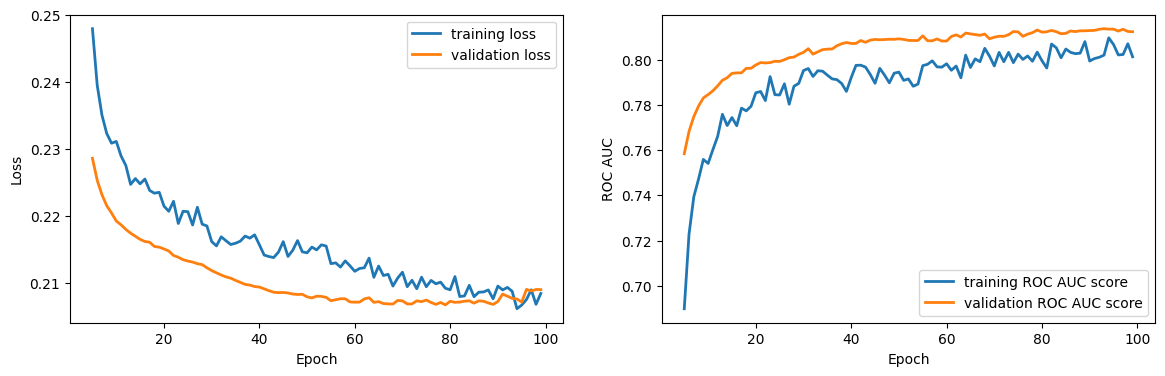

In [108]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [109]:
from sklearn.metrics import roc_auc_score, confusion_matrix

# テストデータでの予測
model = tf.keras.models.load_model('/content/model_0.keras')
y_pred_prob = model.predict(x_test)

# 予測値を二値化 (閾値は0.1)
y_pred = (y_pred_prob > 0.1).astype(int)

# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")

# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.8120132645541636
感度 (Recall): 0.6565217391304348
特異度 (Specificity): 0.8166101694915254


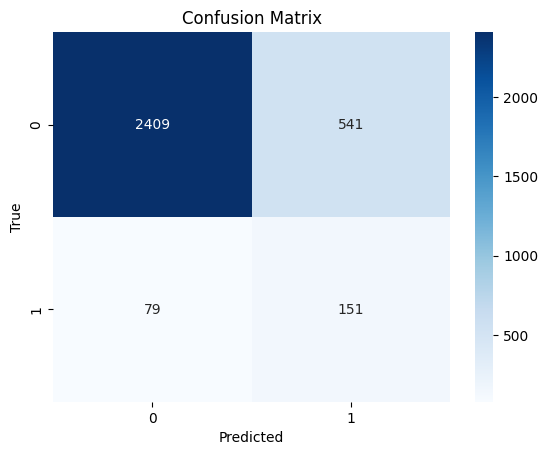

In [110]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()